In [87]:
"""CS231n: Optimization
"""

import numpy as np
import math
import matplotlib.pyplot as plt
import pickle, os, random
from collections import Counter
from ipywidgets import interact, IntSlider, Dropdown
from sklearn.datasets import make_moons, make_circles, make_blobs


In [88]:
# CIFAR-10 Loading Utilities

def load_CIFAR_batch(filename):
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding='bytes')
        X = datadict[b'data']
        Y = datadict[b'labels']
        # reshape to (N, C, H, W) then transpose to (N, H, W, C) for channel-last format
        X = X.reshape(10000, 3, 32, 32).astype("float").transpose(0, 2, 3, 1)
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(folder_path):
    xs, ys = [], []
    for b in range(1, 6):
        f = os.path.join(folder_path, f'data_batch_{b}')
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    Xte, Yte = load_CIFAR_batch(os.path.join(folder_path, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

X_train, y_train, X_test, y_test = load_CIFAR10('../cifar-10-batches-py')

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [89]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [90]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


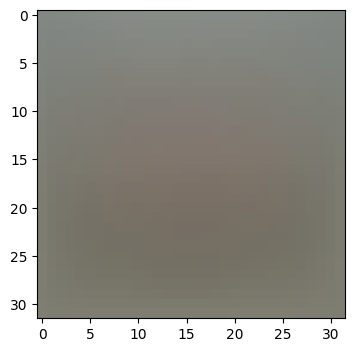

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [91]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our classifier
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

In [92]:
def eval_numerical_gradient(f, x):
  """
  a naive implementation of numerical gradient of f at x
  - f should be a function that takes a single argument
  - x is the point (numpy array) to evaluate the gradient at
  """

  fx = f(x) # evaluate function value at original point
  grad = np.zeros(x.shape)
  h = 0.00001

  # iterate over all indexes in x
  it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
  while not it.finished:

    # evaluate function at x+h
    ix = it.multi_index
    old_value = x[ix]
    x[ix] = old_value + h # increment by h
    fxh = f(x) # evalute f(x + h)
    x[ix] = old_value # restore to previous value (very important!)

    # compute the partial derivative
    grad[ix] = (fxh - fx) / h # the slope
    it.iternext() # step to next dimension

  return grad

def eval_numerical_gradient_array(f, x, df, h=1e-5):
    """
    Evaluate a numeric gradient for a function that accepts a numpy
    array and returns a numpy array.
    """
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=["multi_index"], op_flags=["readwrite"])
    while not it.finished:
        ix = it.multi_index

        oldval = x[ix]
        x[ix] = oldval + h
        pos = f(x).copy()
        x[ix] = oldval - h
        neg = f(x).copy()
        x[ix] = oldval

        grad[ix] = np.sum((pos - neg) * df) / (2 * h)
        it.iternext()
    return grad

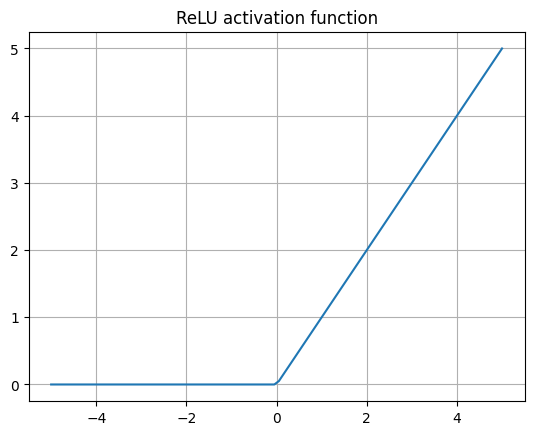

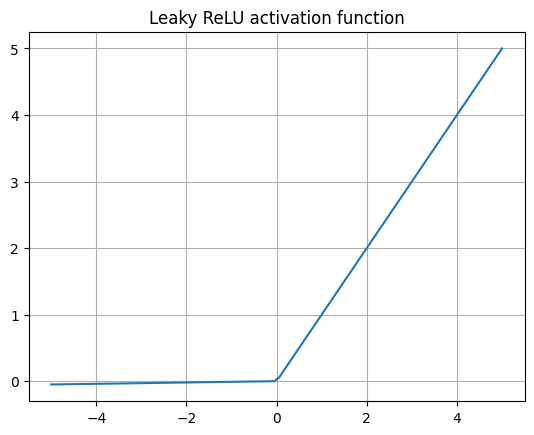

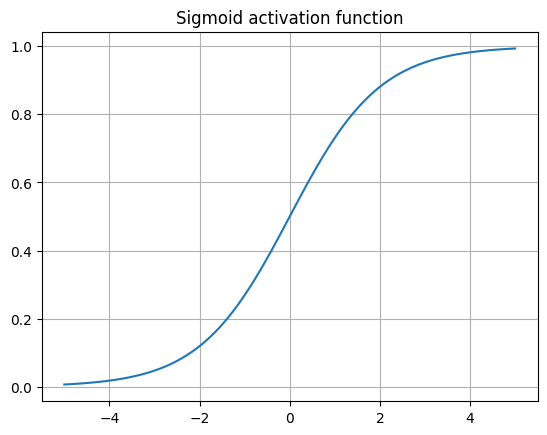

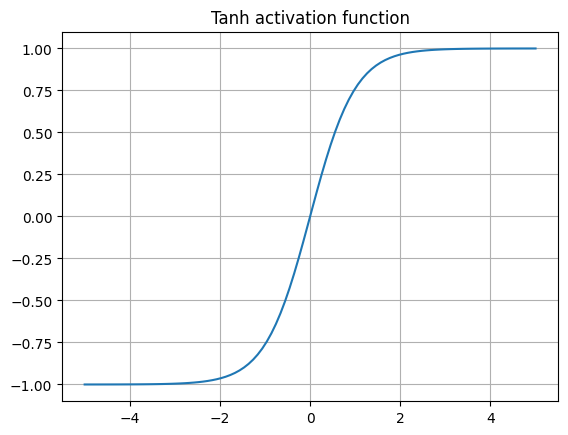

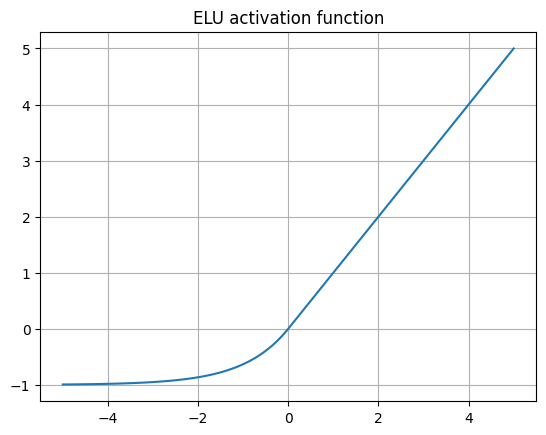

In [93]:
# activation functions

x_grid = np.linspace(-5, 5, 100)

# ReLU
def relu(x):
    return np.maximum(0, x)
plt.plot(x_grid, relu(x_grid))
plt.title("ReLU activation function")
plt.grid()
plt.show()

# Leaky ReLU
def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)
plt.plot(x_grid, leaky_relu(x_grid))
plt.title("Leaky ReLU activation function")
plt.grid()
plt.show()

# Sigmoid
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
plt.plot(x_grid, sigmoid(x_grid))
plt.title("Sigmoid activation function")
plt.grid()
plt.show()

# Tanh
def tanh(x):
    return np.tanh(x)
plt.plot(x_grid, tanh(x_grid))
plt.title("Tanh activation function")
plt.grid()
plt.show()

# ELU
def elu(x, alpha=1.0):
    return np.where(x > 0, x, alpha * (np.exp(x) - 1))
plt.plot(x_grid, elu(x_grid))
plt.title("ELU activation function")
plt.grid()
plt.show()

In [94]:
# Backpropagation 

# set some inputs
x = -2; y = 5; z = -4
print(f'Inputs: x={x}, y={y}, z={z}')

# perform the forward pass
q = x + y # q becomes 3
f = q * z # f becomes -12
print(f'Output of forward pass: f={f}')

# perform the backward pass (backpropagation) in reverse order:
# first backprop through f = q * z
dfdz = q # df/dz = q, so gradient on z becomes 3
dfdq = z # df/dq = z, so gradient on q becomes -4
dqdx = 1.0
dqdy = 1.0
# now backprop through q = x + y
dfdx = dfdq * dqdx  # The multiplication here is the chain rule!
dfdy = dfdq * dqdy  

print(f'Gradient on x: {dfdx}, Gradient on y: {dfdy}, Gradient on z: {dfdz}, Gradient on q: {dfdq}')

Inputs: x=-2, y=5, z=-4
Output of forward pass: f=-12
Gradient on x: -4.0, Gradient on y: -4.0, Gradient on z: 3, Gradient on q: -4


In [95]:
w = [2,-3,-3] # assume some random weights and data
x = [-1, -2]
print(f'Inputs: x={x}, w={w}')

# forward pass
dot = w[0]*x[0] + w[1]*x[1] + w[2]
f = 1.0 / (1 + math.exp(-dot)) # sigmoid function
print(f'Output of forward pass: f={f}')

# backward pass through the neuron (backpropagation)
ddot = (1 - f) * f # gradient on dot variable, using the sigmoid gradient derivation
dx = [w[0] * ddot, w[1] * ddot] # backprop into x
dw = [x[0] * ddot, x[1] * ddot, 1.0 * ddot] # backprop into w

print(f'Gradient on x: \n{dx}, \nGradient on w: \n{dw}')

Inputs: x=[-1, -2], w=[2, -3, -3]
Output of forward pass: f=0.7310585786300049
Gradient on x: 
[0.3932238664829637, -0.5898357997244456], 
Gradient on w: 
[-0.19661193324148185, -0.3932238664829637, 0.19661193324148185]


In [96]:
# Matrix-Matrix multiply gradient

# forward pass
W = np.random.randn(2, 4)
X = np.random.randn(4, 3)
print(f'Inputs: \nW : \n{W}, \nX : \n{X}')
D = W.dot(X)
print(f'Output of forward pass D : \n{D}')

# now suppose we had the gradient on D from above in the circuit
dD = np.random.randn(*D.shape) # same shape as D
dW = dD.dot(X.T) #.T gives the transpose of the matrix
dX = W.T.dot(dD)
print(f'Gradient on W : \n{dW}, \nGradient on X : \n{dX}')

Inputs: 
W : 
[[ 1.17217878 -0.36213406 -1.02798701 -1.40641556]
 [-0.34750558  0.70917623  0.55561118  0.69245006]], 
X : 
[[ 0.02347657  1.0745924  -2.29347265]
 [-1.52236553 -0.04628979  0.39458146]
 [ 1.01334535  0.55929164  0.64587873]
 [-1.3243988   0.52447333  0.83049567]]
Output of forward pass D : 
[[ 1.39976837 -0.03619447 -4.66322834]
 [-1.4418377   0.2676658   2.01075655]]
Gradient on W : 
[[ 1.61458937 -0.8811772  -0.27452925 -1.2946995 ]
 [-1.68449404  1.6367424  -0.06330232  2.08237294]], 
Gradient on X : 
[[ 0.73668987 -0.40996932 -1.26498715]
 [-0.74035834  0.35801438  0.93597776]
 [-0.85980172  0.4559742   1.33662018]
 [-1.11863818  0.59780558  1.76734052]]


In [97]:
# Affine and ReLU functions

def affine_forward(x, w, b):
    """
    Computes the forward pass for an affine (fully-connected) layer.

    The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
    examples, where each example x[i] has shape (d_1, ..., d_k). We will
    reshape each input into a vector of dimension D = d_1 * ... * d_k, and
    then transform it to an output vector of dimension M.

    Inputs:
    - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
    - w: A numpy array of weights, of shape (D, M)
    - b: A numpy array of biases, of shape (M,)

    Returns a tuple of:
    - out: output, of shape (N, M)
    - cache: (x, w, b)
    """
    out = None
    ###########################################################################
    # TODO: Implement the affine forward pass. Store the result in out. You   #
    # will need to reshape the input into rows.                               #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    x_reshaped = x.reshape(x.shape[0], -1)
    out = x_reshaped @ w + b

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    cache = (x, w, b)
    return out, cache


def affine_backward(dout, cache):
    """
    Computes the backward pass for an affine layer.

    Inputs:
    - dout: Upstream derivative, of shape (N, M)
    - cache: Tuple of:
      - x: Input data, of shape (N, d_1, ... d_k)
      - w: Weights, of shape (D, M)
      - b: Biases, of shape (M,)

    Returns a tuple of:
    - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
    - dw: Gradient with respect to w, of shape (D, M)
    - db: Gradient with respect to b, of shape (M,)
    """
    x, w, b = cache
    dx, dw, db = None, None, None
    ###########################################################################
    # TODO: Implement the affine backward pass.                               #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    x_reshaped = x.reshape(x.shape[0], -1)
    dx = (dout @ w.T).reshape(x.shape[0], *x.shape[1:])
    dw = x_reshaped.T @ dout
    db = dout.sum(axis=0)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx, dw, db


def relu_forward(x):
    """
    Computes the forward pass for a layer of rectified linear units (ReLUs).

    Input:
    - x: Inputs, of any shape

    Returns a tuple of:
    - out: Output, of the same shape as x
    - cache: x
    """
    out = None
    ###########################################################################
    # TODO: Implement the ReLU forward pass.                                  #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    out = np.maximum(0, x)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    cache = x
    return out, cache


def relu_backward(dout, cache):
    """
    Computes the backward pass for a layer of rectified linear units (ReLUs).

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    dx, x = None, cache
    ###########################################################################
    # TODO: Implement the ReLU backward pass.                                 #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    dx = dout * (x > 0)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx


def svm_loss(x, y):
    """
    Computes the loss and gradient using for multiclass SVM classification.

    Inputs:
    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth
      class for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """
    loss, dx = None, None
    ###########################################################################
    # TODO: Implement loss and gradient for multiclass SVM classification.    #
    # This will be similar to the svm loss vectorized implementation in       #
    # cs231n/classifiers/linear_svm.py.                                       #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    N = len(y)                                # number of samples
    x_true = x[range(N), y][:, None]          # scores for true labels
    margins = np.maximum(0, x - x_true + 1)   # margin for each score
    loss = margins.sum() / N - 1
    dx = (margins > 0).astype(float) / N
    dx[range(N), y] -= dx.sum(axis=1)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return loss, dx


def softmax_loss(x, y):
    """
    Computes the loss and gradient for softmax classification.

    Inputs:
    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth
      class for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """
    loss, dx = None, None
    ###########################################################################
    # TODO: Implement the loss and gradient for softmax classification. This  #
    # will be similar to the softmax loss vectorized implementation in        #
    # cs231n/classifiers/softmax.py.                                          #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    N = len(y) # number of samples

    P = np.exp(x - x.max(axis=1, keepdims=True)) # numerically stable exponents
    P /= P.sum(axis=1, keepdims=True)            # row-wise probabilities (softmax)

    loss = -np.log(P[range(N), y]).sum() / N # sum cross entropies as loss

    P[range(N), y] -= 1
    dx = P / N

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return loss, dx

def affine_relu_forward(x, w, b):
    """
    Convenience layer that perorms an affine transform followed by a ReLU

    Inputs:
    - x: Input to the affine layer
    - w, b: Weights for the affine layer

    Returns a tuple of:
    - out: Output from the ReLU
    - cache: Object to give to the backward pass
    """
    a, fc_cache = affine_forward(x, w, b)
    out, relu_cache = relu_forward(a)
    cache = (fc_cache, relu_cache)
    return out, cache


def affine_relu_backward(dout, cache):
    """
    Backward pass for the affine-relu convenience layer
    """
    fc_cache, relu_cache = cache
    da = relu_backward(dout, relu_cache)
    dx, dw, db = affine_backward(da, fc_cache)
    return dx, dw, db

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [98]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around e-9 or less.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.769849468192957e-10


In [99]:
# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around e-10 or less
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  5.399100368651805e-11
dw error:  9.904211865398145e-11
db error:  2.4122867568119087e-11


In [100]:
# Testing affine relu forward and backward

np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

# Relative error should be around e-10 or less
print('Testing affine_relu_forward and affine_relu_backward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward and affine_relu_backward:
dx error:  2.299579177309368e-11
dw error:  8.162011105764925e-11
db error:  7.826724021458994e-12


In [101]:
# Testing svm and softmax loss functions

np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be around the order of e-9
print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be close to 2.3 and dx error should be around e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

Testing svm_loss:
loss:  8.999602749096233
dx error:  5.843048666990618e-09

Testing softmax_loss:
loss:  2.3025458445007376
dx error:  2.2674252757911207e-06


In [102]:
def sgd(w, dw, config=None):
    """
    Performs vanilla stochastic gradient descent.

    config format:
    - learning_rate: Scalar learning rate.
    """
    if config is None:
        config = {}
    config.setdefault("learning_rate", 1e-2)
    ###########################################################################
    # TODO: Implement the vanilla stochastic gradient descent update formula. #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    w -= config['learning_rate'] * dw

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return w, config

In [103]:
class TwoLayerNet(object):
    """
    A two-layer fully-connected neural network with ReLU nonlinearity and
    softmax loss that uses a modular layer design. We assume an input dimension
    of D, a hidden dimension of H, and perform classification over C classes.

    The architecure should be affine - relu - affine - softmax.

    Note that this class does not implement gradient descent; instead, it
    will interact with a separate Solver object that is responsible for running
    optimization.

    The learnable parameters of the model are stored in the dictionary
    self.params that maps parameter names to numpy arrays.
    """

    def __init__(
        self,
        input_dim=3 * 32 * 32,
        hidden_dim=100,
        num_classes=10,
        weight_scale=1e-3,
        reg=0.0,
    ):
        """
        Initialize a new network.

        Inputs:
        - input_dim: An integer giving the size of the input
        - hidden_dim: An integer giving the size of the hidden layer
        - num_classes: An integer giving the number of classes to classify
        - weight_scale: Scalar giving the standard deviation for random
          initialization of the weights.
        - reg: Scalar giving L2 regularization strength.
        """
        self.params = {}
        self.reg = reg

        ############################################################################
        # TODO: Initialize the weights and biases of the two-layer net. Weights    #
        # should be initialized from a Gaussian centered at 0.0 with               #
        # standard deviation equal to weight_scale, and biases should be           #
        # initialized to zero. All weights and biases should be stored in the      #
        # dictionary self.params, with first layer weights                         #
        # and biases using the keys 'W1' and 'b1' and second layer                 #
        # weights and biases using the keys 'W2' and 'b2'.                         #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        self.params = {
          'W1': np.random.randn(input_dim, hidden_dim) * weight_scale,
          'b1': np.zeros(hidden_dim),
          'W2': np.random.randn(hidden_dim, num_classes) * weight_scale,
          'b2': np.zeros(num_classes)
        }

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

    def loss(self, X, y=None):
        """
        Compute loss and gradient for a minibatch of data.

        Inputs:
        - X: Array of input data of shape (N, d_1, ..., d_k)
        - y: Array of labels, of shape (N,). y[i] gives the label for X[i].

        Returns:
        If y is None, then run a test-time forward pass of the model and return:
        - scores: Array of shape (N, C) giving classification scores, where
          scores[i, c] is the classification score for X[i] and class c.

        If y is not None, then run a training-time forward and backward pass and
        return a tuple of:
        - loss: Scalar value giving the loss
        - grads: Dictionary with the same keys as self.params, mapping parameter
          names to gradients of the loss with respect to those parameters.
        """
        scores = None
        ############################################################################
        # TODO: Implement the forward pass for the two-layer net, computing the    #
        # class scores for X and storing them in the scores variable.              #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        W1, b1, W2, b2 = self.params.values()

        out1, cache1 = affine_forward(X, W1, b1)
        out2, cache2 = relu_forward(out1)
        scores, cache3 = affine_forward(out2, W2, b2)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # If y is None then we are in test mode so just return scores
        if y is None:
            return scores

        loss, grads = 0, {}
        ############################################################################
        # TODO: Implement the backward pass for the two-layer net. Store the loss  #
        # in the loss variable and gradients in the grads dictionary. Compute data #
        # loss using softmax, and make sure that grads[k] holds the gradients for  #
        # self.params[k]. Don't forget to add L2 regularization!                   #
        #                                                                          #
        # NOTE: To ensure that your implementation matches ours and you pass the   #
        # automated tests, make sure that your L2 regularization includes a factor #
        # of 0.5 to simplify the expression for the gradient.                      #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        loss, dloss = softmax_loss(scores, y)
        loss += 0.5 * self.reg * (np.sum(W1**2) + np.sum(W2**2))

        dout3, dW2, db2 = affine_backward(dloss, cache3)
        dout2 = relu_backward(dout3, cache2)
        dout1, dW1, db1 = affine_backward(dout2, cache1)

        dW1 += self.reg * W1
        dW2 += self.reg * W2

        grads = {'W1': dW1, 'b1': db1, 'W2': dW2, 'b2': db2}

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        return loss, grads

In [104]:
# Testing the TwoLayerNet class

np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

# Errors should be around e-7 or less
for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name])
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 2.44e-08
W2 relative error: 3.14e-05
b1 relative error: 9.83e-09
b2 relative error: 5.74e-06
Running numeric gradient check with reg =  0.7
W1 relative error: 1.10e-02
W2 relative error: 4.47e-03
b1 relative error: 1.56e-08
b2 relative error: 5.74e-06


In [113]:
class Solver(object):
    """
    A Solver encapsulates all the logic necessary for training classification
    models. The Solver performs stochastic gradient descent using different
    update rules defined in optim.py.

    The solver accepts both training and validation data and labels so it can
    periodically check classification accuracy on both training and validation
    data to watch out for overfitting.

    To train a model, you will first construct a Solver instance, passing the
    model, dataset, and various options (learning rate, batch size, etc) to the
    constructor. You will then call the train() method to run the optimization
    procedure and train the model.

    After the train() method returns, model.params will contain the parameters
    that performed best on the validation set over the course of training.
    In addition, the instance variable solver.loss_history will contain a list
    of all losses encountered during training and the instance variables
    solver.train_acc_history and solver.val_acc_history will be lists of the
    accuracies of the model on the training and validation set at each epoch.

    Example usage might look something like this:

    data = {
      'X_train': # training data
      'y_train': # training labels
      'X_val': # validation data
      'y_val': # validation labels
    }
    model = MyAwesomeModel(hidden_size=100, reg=10)
    solver = Solver(model, data,
                    update_rule='sgd',
                    optim_config={
                      'learning_rate': 1e-3,
                    },
                    lr_decay=0.95,
                    num_epochs=10, batch_size=100,
                    print_every=100)
    solver.train()


    A Solver works on a model object that must conform to the following API:

    - model.params must be a dictionary mapping string parameter names to numpy
      arrays containing parameter values.

    - model.loss(X, y) must be a function that computes training-time loss and
      gradients, and test-time classification scores, with the following inputs
      and outputs:

      Inputs:
      - X: Array giving a minibatch of input data of shape (N, d_1, ..., d_k)
      - y: Array of labels, of shape (N,) giving labels for X where y[i] is the
        label for X[i].

      Returns:
      If y is None, run a test-time forward pass and return:
      - scores: Array of shape (N, C) giving classification scores for X where
        scores[i, c] gives the score of class c for X[i].

      If y is not None, run a training time forward and backward pass and
      return a tuple of:
      - loss: Scalar giving the loss
      - grads: Dictionary with the same keys as self.params mapping parameter
        names to gradients of the loss with respect to those parameters.
    """

    def __init__(self, model, data, **kwargs):
        """
        Construct a new Solver instance.

        Required arguments:
        - model: A model object conforming to the API described above
        - data: A dictionary of training and validation data containing:
          'X_train': Array, shape (N_train, d_1, ..., d_k) of training images
          'X_val': Array, shape (N_val, d_1, ..., d_k) of validation images
          'y_train': Array, shape (N_train,) of labels for training images
          'y_val': Array, shape (N_val,) of labels for validation images

        Optional arguments:
        - update_rule: A string giving the name of an update rule in optim.py.
          Default is 'sgd'.
        - optim_config: A dictionary containing hyperparameters that will be
          passed to the chosen update rule. Each update rule requires different
          hyperparameters (see optim.py) but all update rules require a
          'learning_rate' parameter so that should always be present.
        - lr_decay: A scalar for learning rate decay; after each epoch the
          learning rate is multiplied by this value.
        - batch_size: Size of minibatches used to compute loss and gradient
          during training.
        - num_epochs: The number of epochs to run for during training.
        - print_every: Integer; training losses will be printed every
          print_every iterations.
        - verbose: Boolean; if set to false then no output will be printed
          during training.
        - num_train_samples: Number of training samples used to check training
          accuracy; default is 1000; set to None to use entire training set.
        - num_val_samples: Number of validation samples to use to check val
          accuracy; default is None, which uses the entire validation set.
        - checkpoint_name: If not None, then save model checkpoints here every
          epoch.
        """
        self.model = model
        self.X_train = data["X_train"]
        self.y_train = data["y_train"]
        self.X_val = data["X_val"]
        self.y_val = data["y_val"]

        # Unpack keyword arguments
        self.update_rule = kwargs.pop("update_rule", "sgd")
        self.optim_config = kwargs.pop("optim_config", {})
        self.lr_decay = kwargs.pop("lr_decay", 1.0)
        self.batch_size = kwargs.pop("batch_size", 100)
        self.num_epochs = kwargs.pop("num_epochs", 10)
        self.num_train_samples = kwargs.pop("num_train_samples", 1000)
        self.num_val_samples = kwargs.pop("num_val_samples", None)
        # reduce learning rate at milestones
        self.lr_milestones = kwargs.pop('lr_milestones', None)           
        self.lr_milestone_factor = kwargs.pop('lr_milestone_factor', 0.1) 

        self.checkpoint_name = kwargs.pop("checkpoint_name", None)
        self.print_every = kwargs.pop("print_every", 10)
        self.verbose = kwargs.pop("verbose", True)

        # Throw an error if there are extra keyword arguments
        if len(kwargs) > 0:
            extra = ", ".join('"%s"' % k for k in list(kwargs.keys()))
            raise ValueError("Unrecognized arguments %s" % extra)

        # Make sure the update rule exists, then replace the string
        # name with the actual function
        # if not hasattr(sgd, self.update_rule):
        #     raise ValueError('Invalid update_rule "%s"' % self.update_rule)
        self.update_rule = sgd

        self._reset()

    def _reset(self):
        """
        Set up some book-keeping variables for optimization. Don't call this
        manually.
        """
        # Set up some variables for book-keeping
        self.epoch = 0
        self.best_val_acc = 0
        self.best_params = {}
        self.loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []

        # Make a deep copy of the optim_config for each parameter
        self.optim_configs = {}
        for p in self.model.params:
            d = {k: v for k, v in self.optim_config.items()}
            self.optim_configs[p] = d

    def _step(self):
        """
        Make a single gradient update. This is called by train() and should not
        be called manually.
        """
        # Make a minibatch of training data
        num_train = self.X_train.shape[0]
        batch_mask = np.random.choice(num_train, self.batch_size)
        X_batch = self.X_train[batch_mask]
        y_batch = self.y_train[batch_mask]

        # Compute loss and gradient
        loss, grads = self.model.loss(X_batch, y_batch)
        self.loss_history.append(loss)

        # Perform a parameter update
        for p, w in self.model.params.items():
            dw = grads[p]
            config = self.optim_configs[p]
            next_w, next_config = self.update_rule(w, dw, config)
            self.model.params[p] = next_w
            self.optim_configs[p] = next_config

    def _save_checkpoint(self):
        if self.checkpoint_name is None:
            return
        checkpoint = {
            "model": self.model,
            "update_rule": self.update_rule,
            "lr_decay": self.lr_decay,
            "optim_config": self.optim_config,
            "batch_size": self.batch_size,
            "num_train_samples": self.num_train_samples,
            "num_val_samples": self.num_val_samples,
            "epoch": self.epoch,
            "loss_history": self.loss_history,
            "train_acc_history": self.train_acc_history,
            "val_acc_history": self.val_acc_history,
        }
        filename = "%s_epoch_%d.pkl" % (self.checkpoint_name, self.epoch)
        if self.verbose:
            print('Saving checkpoint to "%s"' % filename)
        with open(filename, "wb") as f:
            pickle.dump(checkpoint, f)

    def check_accuracy(self, X, y, num_samples=None, batch_size=100):
        """
        Check accuracy of the model on the provided data.

        Inputs:
        - X: Array of data, of shape (N, d_1, ..., d_k)
        - y: Array of labels, of shape (N,)
        - num_samples: If not None, subsample the data and only test the model
          on num_samples datapoints.
        - batch_size: Split X and y into batches of this size to avoid using
          too much memory.

        Returns:
        - acc: Scalar giving the fraction of instances that were correctly
          classified by the model.
        """

        # Maybe subsample the data
        N = X.shape[0]
        if num_samples is not None and N > num_samples:
            mask = np.random.choice(N, num_samples)
            N = num_samples
            X = X[mask]
            y = y[mask]

        # Compute predictions in batches
        num_batches = N // batch_size
        if N % batch_size != 0:
            num_batches += 1
        y_pred = []
        for i in range(num_batches):
            start = i * batch_size
            end = (i + 1) * batch_size
            scores = self.model.loss(X[start:end])
            y_pred.append(np.argmax(scores, axis=1))
        y_pred = np.hstack(y_pred)
        acc = np.mean(y_pred == y)

        return acc

    def train(self):
        """
        Run optimization to train the model.
        """
        num_train = self.X_train.shape[0]
        iterations_per_epoch = max(num_train // self.batch_size, 1)
        num_iterations = self.num_epochs * iterations_per_epoch

        for t in range(num_iterations):
            self._step()

            # Maybe print training loss
            if self.verbose and t % self.print_every == 0:
                print(
                    "(Iteration %d / %d) loss: %f"
                    % (t + 1, num_iterations, self.loss_history[-1])
                )

            # At the end of every epoch, increment the epoch counter and decay
            # the learning rate.
            epoch_end = (t + 1) % iterations_per_epoch == 0
            # if epoch_end:
            #     self.epoch += 1
            #     for k in self.optim_configs:
            #         self.optim_configs[k]["learning_rate"] *= self.lr_decay
            if epoch_end:
                # increment epoch counter first (keeps existing semantics)
                self.epoch += 1

                # If user provided milestone schedule, and current epoch matches one, apply milestone factor.
                # Otherwise fall back to per-epoch decay self.lr_decay (existing behavior).
                if self.lr_milestones is not None and self.epoch in self.lr_milestones:
                    factor = self.lr_milestone_factor
                    if self.verbose:
                        print(f'==> Epoch {self.epoch}: applying milestone LR multiply by {factor}')
                    for k in self.optim_configs:
                        self.optim_configs[k]['learning_rate'] *= factor
                else:
                    # default per-epoch multiplicative decay (existing behavior)
                    for k in self.optim_configs:
                        self.optim_configs[k]['learning_rate'] *= self.lr_decay

            # Check train and val accuracy on the first iteration, the last
            # iteration, and at the end of each epoch.
            first_it = t == 0
            last_it = t == num_iterations - 1
            if first_it or last_it or epoch_end:
                train_acc = self.check_accuracy(
                    self.X_train, self.y_train, num_samples=self.num_train_samples
                )
                val_acc = self.check_accuracy(
                    self.X_val, self.y_val, num_samples=self.num_val_samples
                )
                self.train_acc_history.append(train_acc)
                self.val_acc_history.append(val_acc)
                self._save_checkpoint()

                if self.verbose:
                    print(
                        "(Epoch %d / %d) train acc: %f; val_acc: %f"
                        % (self.epoch, self.num_epochs, train_acc, val_acc)
                    )

                # Keep track of the best model
                if val_acc > self.best_val_acc:
                    self.best_val_acc = val_acc
                    self.best_params = {}
                    for k, v in self.model.params.items():
                        self.best_params[k] = v.copy()

        # At the end of training swap the best params into the model
        self.model.params = self.best_params

In [106]:
# Use a Solver instance to train a TwoLayerNet that achieves about 36% accuracy on the validation set.

input_size = 32 * 32 * 3 + 1
hidden_size = 50
num_classes = 10
model = TwoLayerNet(input_size, hidden_size, num_classes)
solver = None

data = {
  'X_train': X_train,
  'y_train': y_train,
  'X_val': X_val,
  'y_val': y_val,
  'X_test': X_test,
  'y_test': y_test
}

solver = Solver(model, data, optim_config={'learning_rate': 1e-3})
solver.train()

(Iteration 1 / 4900) loss: 2.300763
(Epoch 0 / 10) train acc: 0.122000; val_acc: 0.121000
(Iteration 11 / 4900) loss: 2.270525
(Iteration 21 / 4900) loss: 2.191812
(Iteration 31 / 4900) loss: 2.139185


(Iteration 41 / 4900) loss: 2.038315
(Iteration 51 / 4900) loss: 1.977889
(Iteration 61 / 4900) loss: 1.850302
(Iteration 71 / 4900) loss: 1.954049
(Iteration 81 / 4900) loss: 1.839462
(Iteration 91 / 4900) loss: 1.917509
(Iteration 101 / 4900) loss: 1.996976
(Iteration 111 / 4900) loss: 1.787224
(Iteration 121 / 4900) loss: 1.726060
(Iteration 131 / 4900) loss: 1.823594
(Iteration 141 / 4900) loss: 1.847285
(Iteration 151 / 4900) loss: 1.506664
(Iteration 161 / 4900) loss: 1.871286
(Iteration 171 / 4900) loss: 1.848713
(Iteration 181 / 4900) loss: 1.930756
(Iteration 191 / 4900) loss: 1.781811
(Iteration 201 / 4900) loss: 1.732583
(Iteration 211 / 4900) loss: 1.643623
(Iteration 221 / 4900) loss: 1.854837
(Iteration 231 / 4900) loss: 1.743305
(Iteration 241 / 4900) loss: 1.849336
(Iteration 251 / 4900) loss: 1.577001
(Iteration 261 / 4900) loss: 1.669183
(Iteration 271 / 4900) loss: 1.665335
(Iteration 281 / 4900) loss: 1.583814
(Iteration 291 / 4900) loss: 1.718442
(Iteration 301 / 4

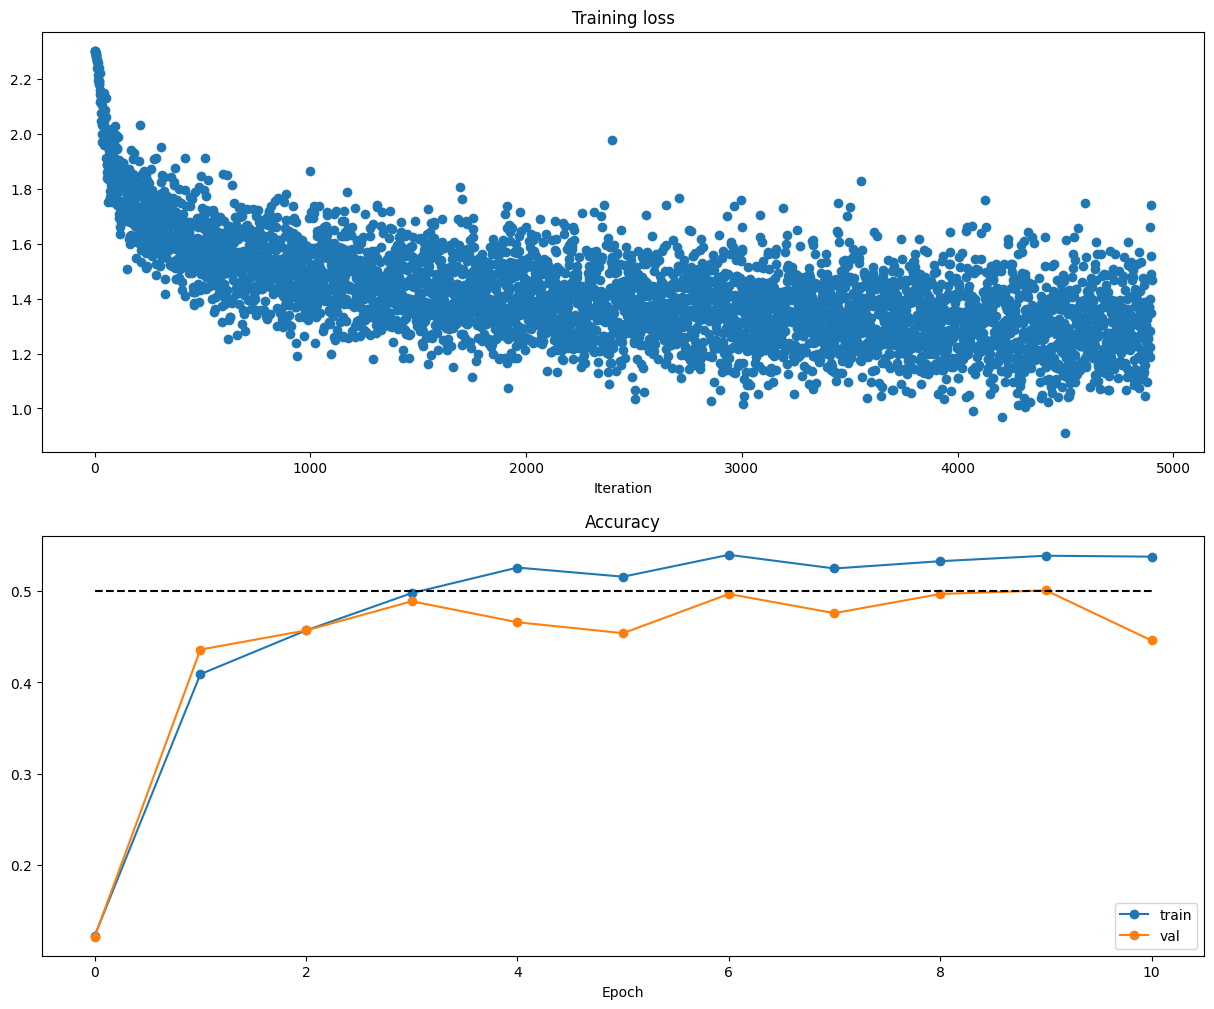

In [110]:
# Visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

In [115]:
# Show learning rate decay effect

model = TwoLayerNet(input_size, hidden_size, num_classes)
solver = Solver(model, data,
                optim_config={'learning_rate': 1e-3},
                lr_decay=1.0,                    # keep per-epoch decay 1.0 if you only want milestone changes
                lr_milestones=[30, 60, 90],      # epochs where LR will be multiplied
                lr_milestone_factor=0.1,         # multiply by 0.1 at those epochs
                num_epochs=100,
                batch_size=200,
                print_every=100)
solver.train()

(Iteration 1 / 24500) loss: 2.304012
(Epoch 0 / 100) train acc: 0.119000; val_acc: 0.118000
(Iteration 101 / 24500) loss: 1.864641
(Iteration 201 / 24500) loss: 1.583199
(Epoch 1 / 100) train acc: 0.403000; val_acc: 0.417000
(Iteration 301 / 24500) loss: 1.727324
(Iteration 401 / 24500) loss: 1.613579
(Epoch 2 / 100) train acc: 0.458000; val_acc: 0.455000
(Iteration 501 / 24500) loss: 1.435262
(Iteration 601 / 24500) loss: 1.499091
(Iteration 701 / 24500) loss: 1.479823
(Epoch 3 / 100) train acc: 0.474000; val_acc: 0.466000
(Iteration 801 / 24500) loss: 1.407193
(Iteration 901 / 24500) loss: 1.557287
(Epoch 4 / 100) train acc: 0.495000; val_acc: 0.475000
(Iteration 1001 / 24500) loss: 1.575976
(Iteration 1101 / 24500) loss: 1.444981
(Iteration 1201 / 24500) loss: 1.404168
(Epoch 5 / 100) train acc: 0.501000; val_acc: 0.481000
(Iteration 1301 / 24500) loss: 1.443809
(Iteration 1401 / 24500) loss: 1.462222
(Epoch 6 / 100) train acc: 0.492000; val_acc: 0.458000
(Iteration 1501 / 24500) lo

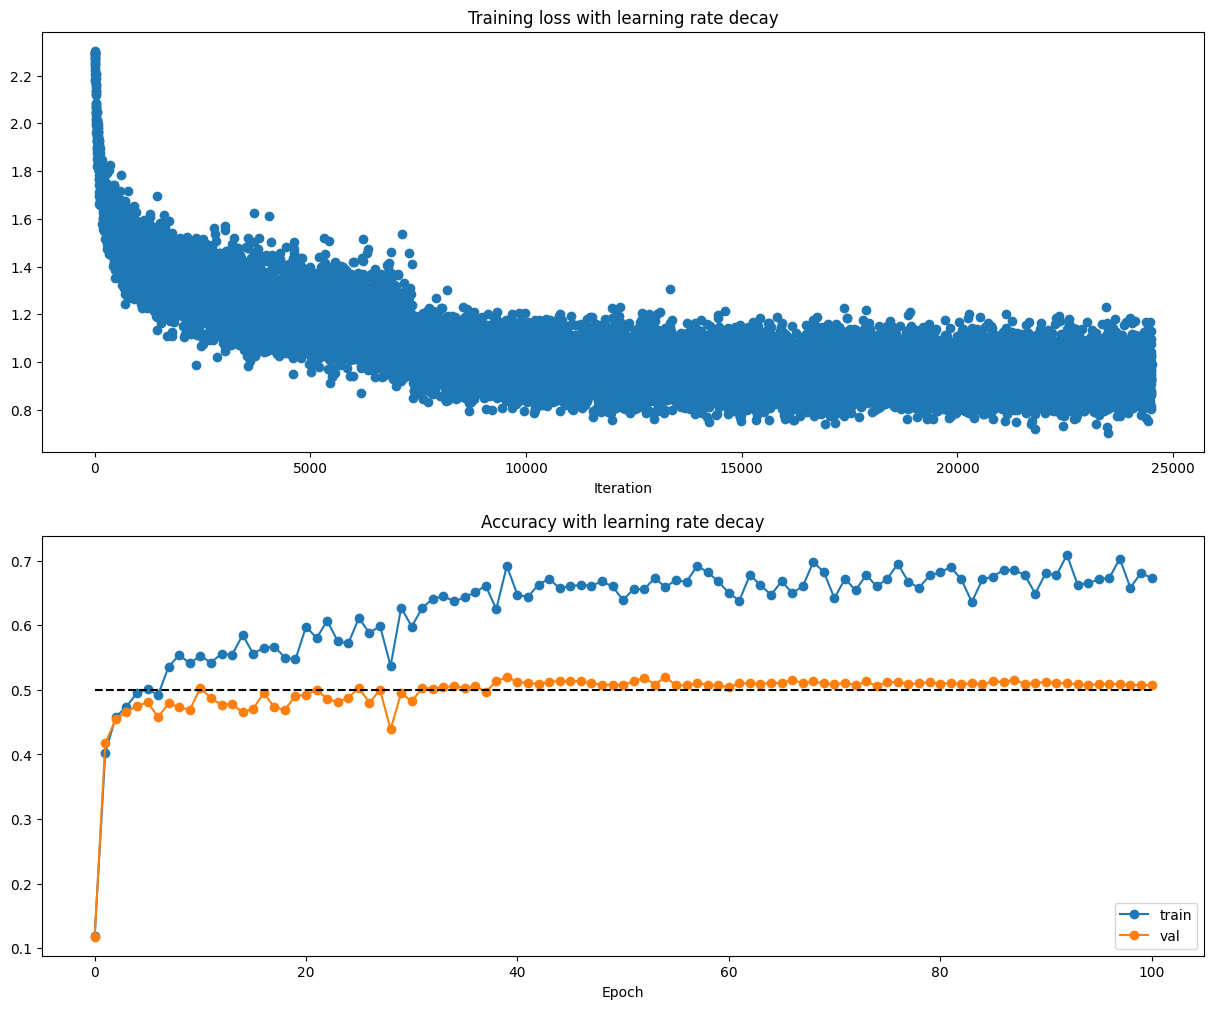

In [117]:

# Visualize training loss and train / val accuracy
plt.subplot(2, 1, 1)
plt.title('Training loss with learning rate decay')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')
plt.subplot(2, 1, 2)
plt.title('Accuracy with learning rate decay')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

